In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

# Load data

In [2]:
seed = 9033

In [3]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
print('Loading data')
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample = 1.0,
                                                    propn_labeled = 0.1)

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=40,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=100,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=100,
                shuffle=False)

Loading data


In [4]:
seed = 4353

np.random.seed(seed)
_ = torch.manual_seed(seed)

for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break

for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break

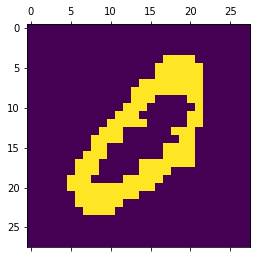

In [5]:
plt.matshow(data_labeled['image'][0, :, :])

In [6]:
slen = data_labeled['image'].shape[-1]

# Define VAE

In [7]:
latent_dim = 32
n_classes = 10

In [8]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [9]:
# Load results

file_base = '../mnist_vae_results_aws/mnist_vae_semisuper'

enc_file = file_base + '_enc_final'
dec_file = file_base + '_dec_final'
classifier_file = file_base + '_classifier_final'

# enc_file = "../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_enc_final"
# dec_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_dec_final'
# classifier_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_classifier_final'


vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=64, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=10, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=42, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [10]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=64, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=10, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=42, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)>


# Check losses

In [11]:
loss_array = np.loadtxt(file_base + 'loss_array.txt')

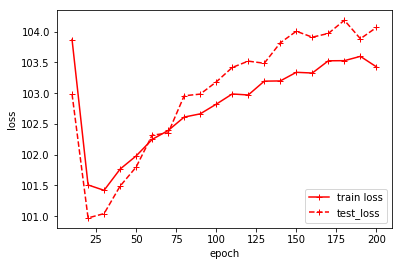

In [12]:
# plot losses
start_indx = 1

plt.plot(loss_array[0, start_indx:], loss_array[1, start_indx:], 'r-+')
plt.plot(loss_array[0, start_indx:], loss_array[2, start_indx:], 'r--+')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('train loss', 'test_loss'))

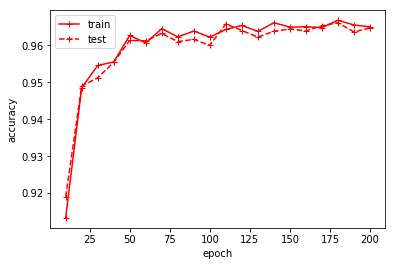

In [13]:
# plot trianing accuracy
plt.plot(loss_array[0, start_indx:], loss_array[3, start_indx:], 'r-+')
plt.plot(loss_array[0, start_indx:], loss_array[4, start_indx:], 'r--+')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(('train', 'test'))

In [14]:
vae.loss(data_unlabeled['image'])[0]

tensor(107.2234)

In [15]:
vae.loss(test_data['image'])[0]

tensor(101.6082)

# Look at classification accuracies 

In [16]:
labeled_accuracy, labeled_wrong_images, labeled_wrong_labels = \
    mnist_vae_lib.get_classification_accuracy(train_loader_labeled, vae.classifier, return_wrong_images = True)
    
print(labeled_accuracy)

tensor(0.9731)


In [17]:
unlabeled_accuracy, unlabeled_wrong_images, unlabeled_wrong_labels= \
    mnist_vae_lib.get_classification_accuracy(train_loader_unlabeled, vae.classifier, return_wrong_images = True)
    
print(unlabeled_accuracy)

tensor(0.9727)


In [18]:
test_accuracy, test_wrong_images, unlabeled_wrong_labels = \
    mnist_vae_lib.get_classification_accuracy(test_loader, vae.classifier, return_wrong_images = True)
    
print(test_accuracy)

tensor(0.9673)


# Check reconstructions

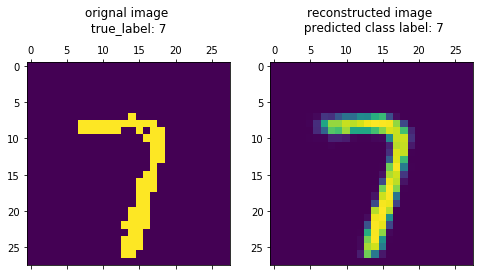

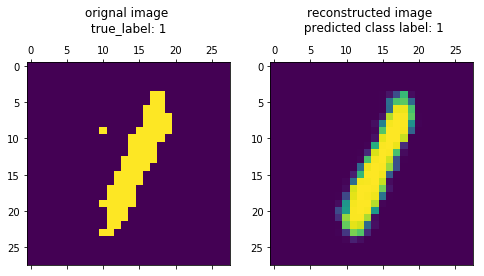

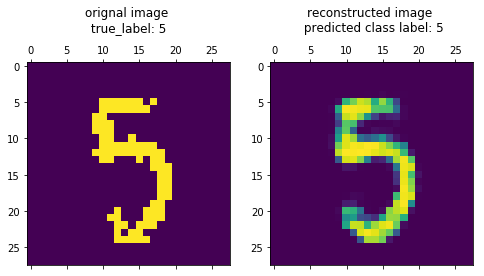

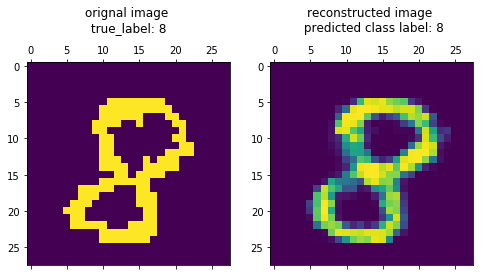

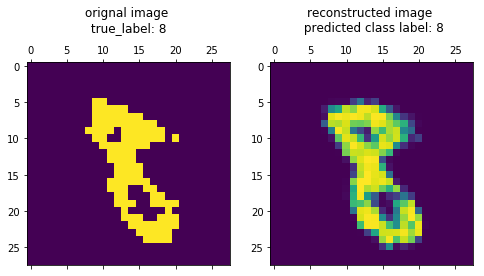

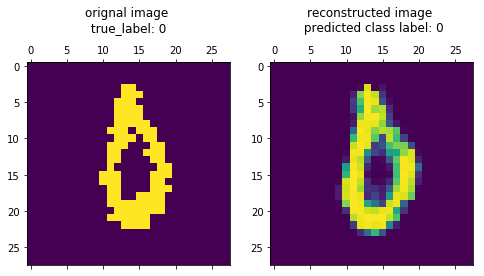

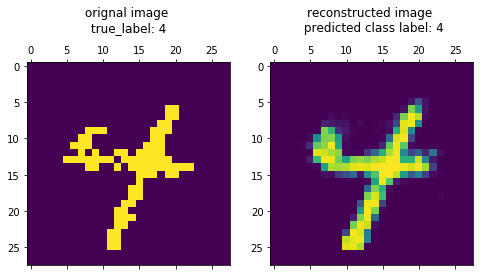

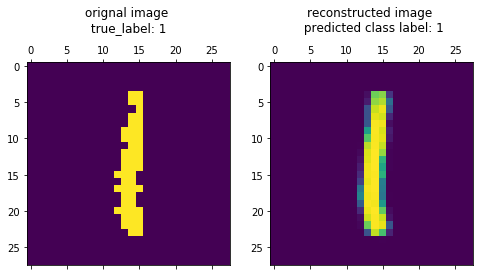

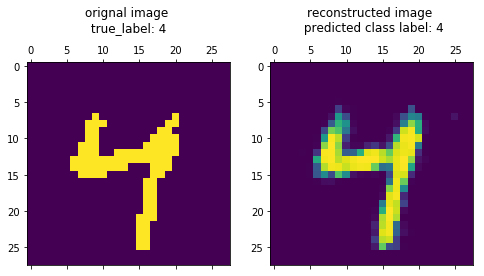

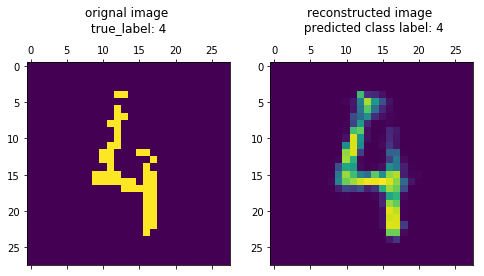

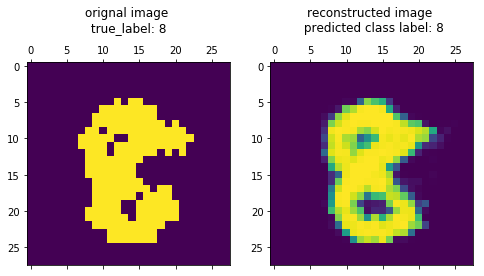

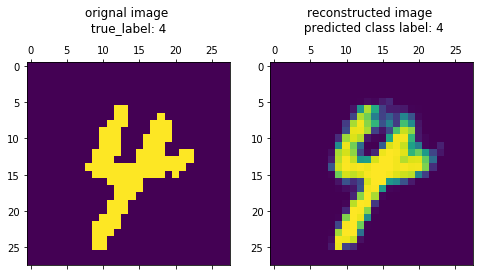

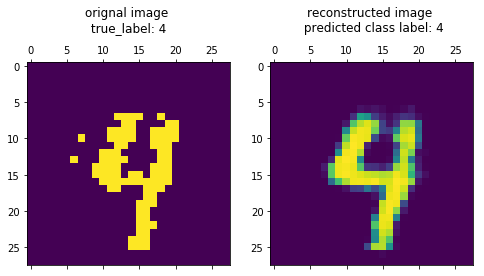

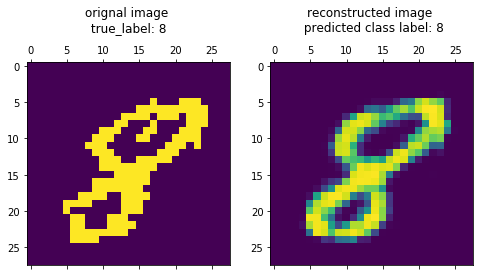

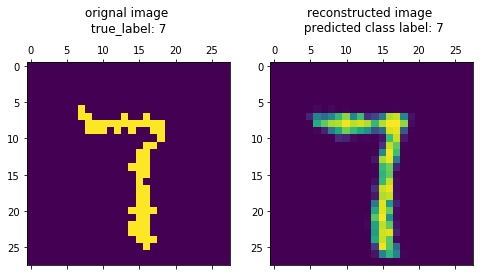

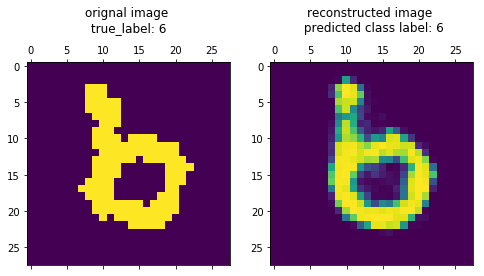

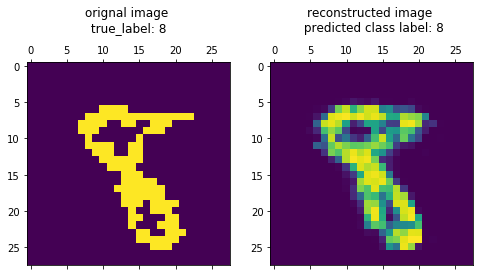

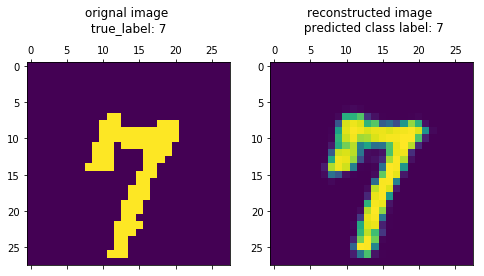

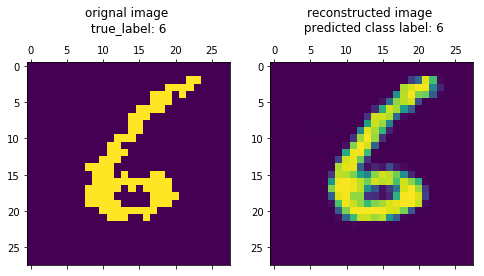

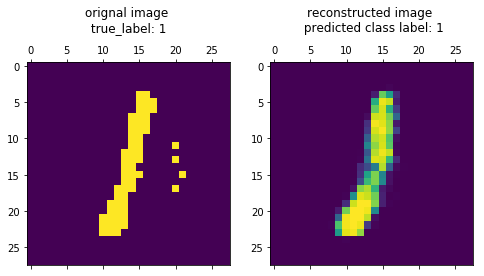

In [19]:
# Look at training images

image_mu, z_ind = mnist_vae_lib.get_reconstructions(vae, data_unlabeled['image'])

figsize = 8
for i in range(0, 20): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(data_unlabeled['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n true_label: {} \n'.format(data_unlabeled['label'][i]))
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))

In [20]:
# Check the training images that were wrong

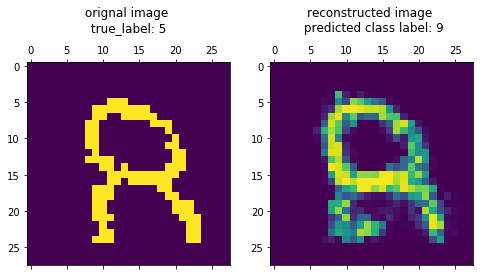

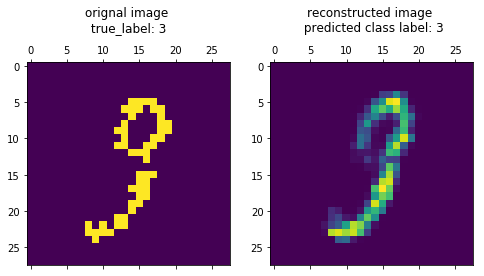

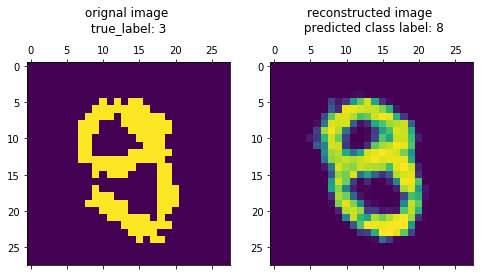

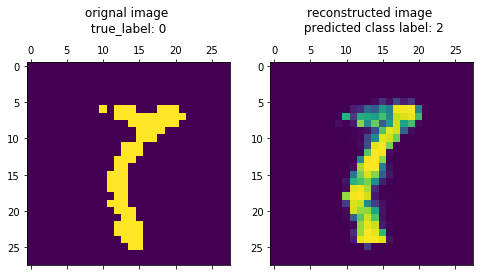

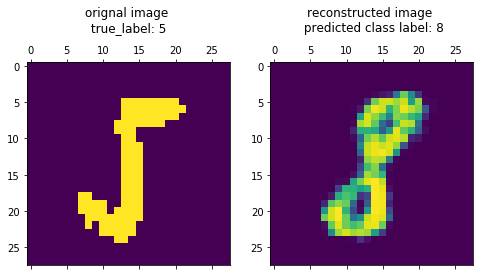

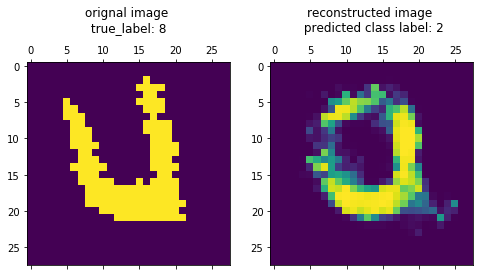

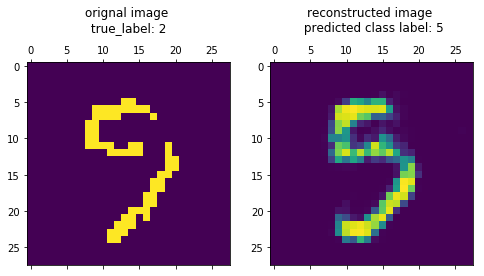

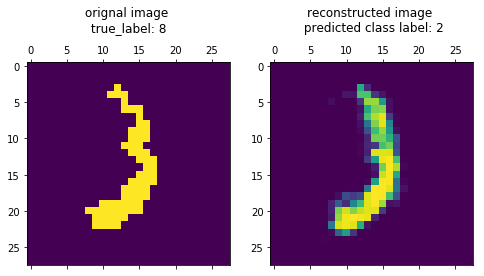

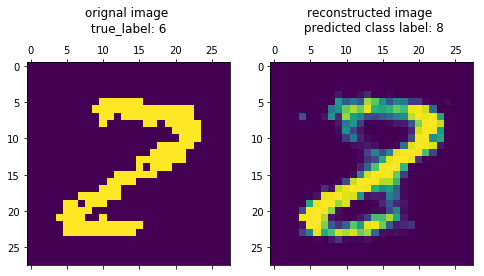

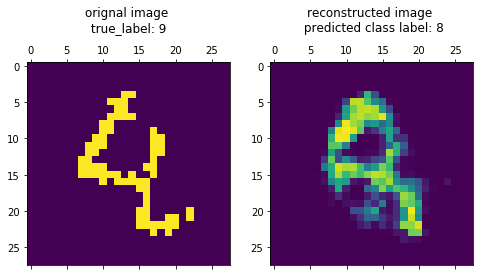

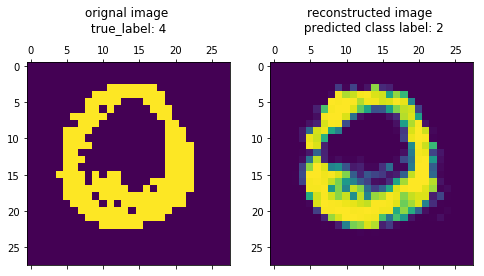

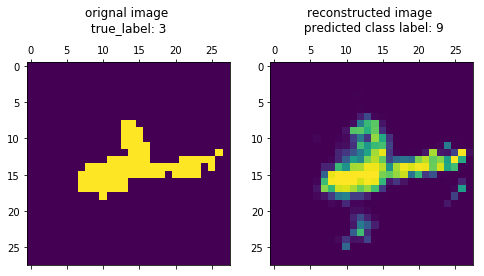

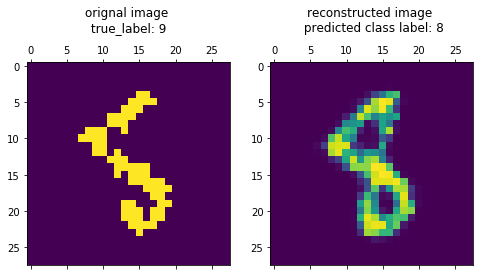

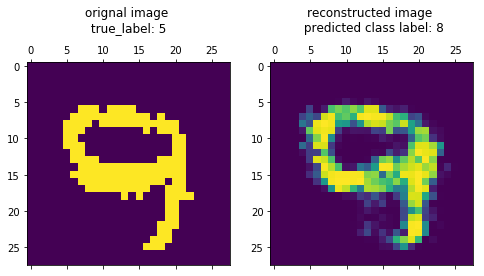

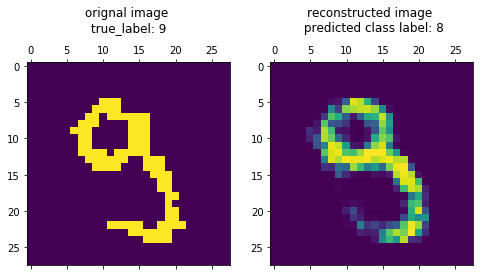

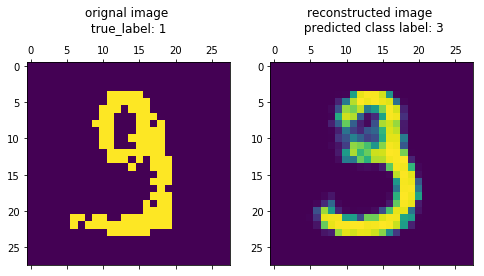

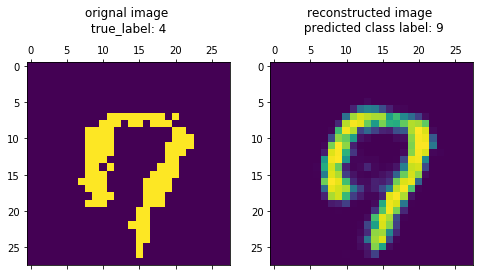

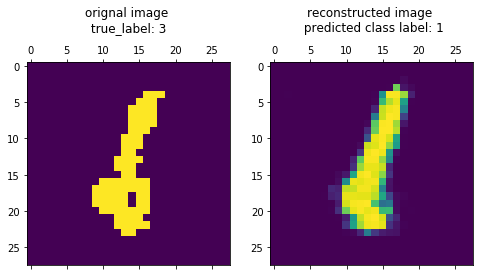

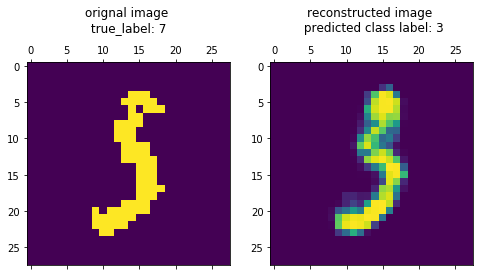

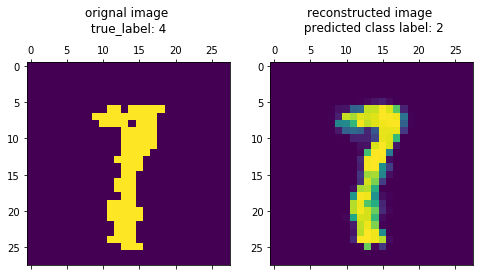

In [21]:
image_mu, z_ind = mnist_vae_lib.get_reconstructions(vae, unlabeled_wrong_images)

figsize = 8
for i in range(0, 20): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(unlabeled_wrong_images[i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n true_label: {} \n'.format(unlabeled_wrong_labels[i]))
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))

In [22]:
# check a few test images 

In [23]:
class_weights = vae.classifier(test_data['image'])

z_ind = torch.argmax(class_weights, dim = 1)
z_ind_one_hot = common_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

latent_means, latent_std, latent_samples = \
    vae.encoder_forward(data_unlabeled['image'], z_ind_one_hot)

    
image_mu = vae.decoder_forward(latent_means, z_ind_one_hot)

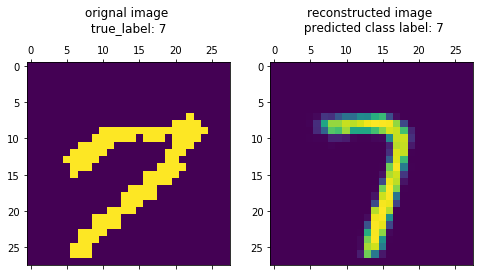

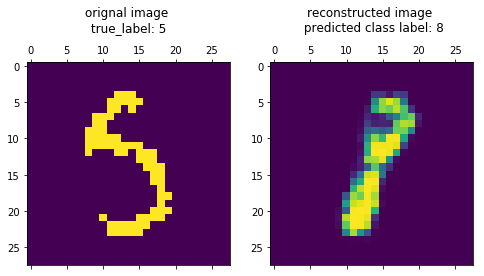

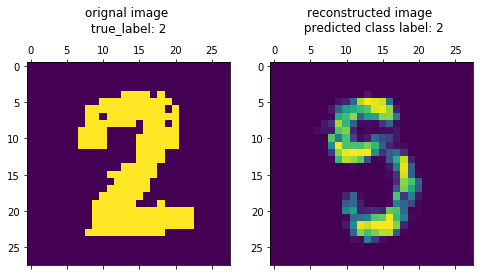

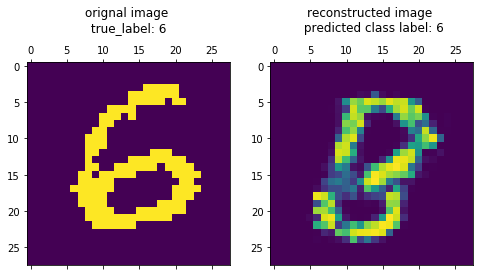

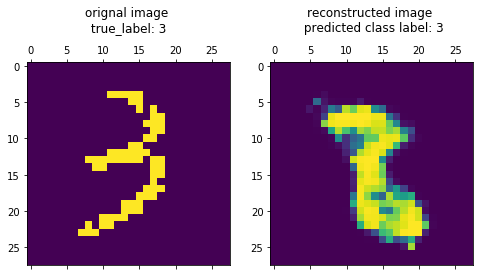

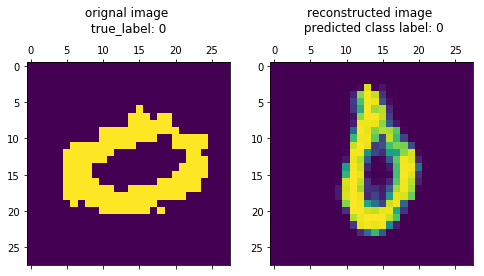

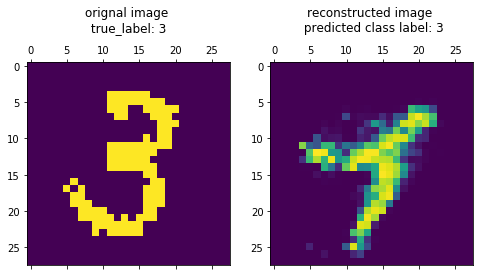

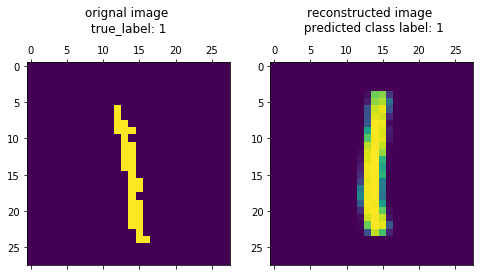

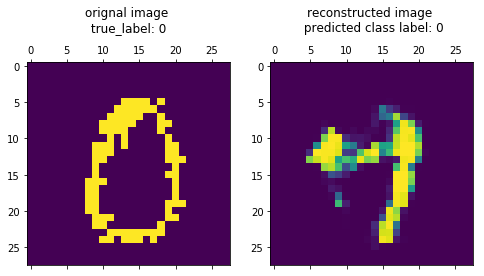

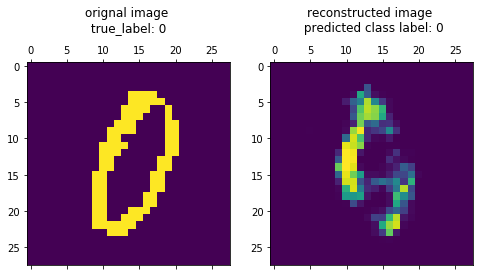

In [24]:
figsize = 8
for i in range(0, 10): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(test_data['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n true_label: {} \n'.format(test_data['label'][i]))
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))

# check conditional generation

In [25]:
num = 10
latent_params = torch.randn((10, latent_dim))

digit = 6
one_hot_z = common_utils.get_one_hot_encoding_from_int(torch.ones(num) * digit, n_classes)
recon_mean = vae.decoder_forward(latent_params, one_hot_z)

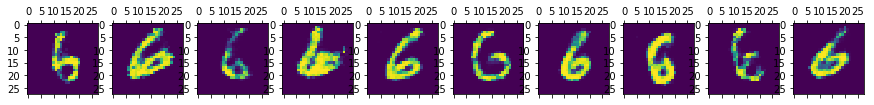

In [26]:
f, axarr = plt.subplots(1, num, figsize=(15, 15))

for i in range(0, num): 
    axarr[i].matshow(recon_mean[i, :, :].detach())
